In [1]:
import os
import pyspark
from pyspark.sql import SparkSession, functions as F

os.environ["SPARK_HOME"] = pyspark.__path__[0]
os.environ["PYSPARK_DRIVER_PYTHON"] = "python"
os.environ["PYSPARK_PYTHON"] = "python"

spark = (
    SparkSession.builder
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

In [2]:
! ls ../data

initial_sample.json
islander_levels_20210521.json
islander_ranking_20210521.json
magician_levels_20210521.json
magician_ranking_20210521.json
sample_20210509.sqlite
sample_levels_20210509.json
sample_ranking_20210509.json


In [9]:
levels = spark.read.json("../data/magician_levels_20210521.json", multiLine=True).cache()
levels.printSchema()
levels.show(n=5)

root
 |-- level: long (nullable = true)
 |-- name: string (nullable = true)
 |-- timestamp: string (nullable = true)

+-----+-------+-------------------+
|level|   name|          timestamp|
+-----+-------+-------------------+
|  200|Unlucky|2016-08-07 16:27:09|
|  199|Unlucky|2016-07-24 12:45:27|
|  198|Unlucky|2016-07-14 07:50:14|
|  197|Unlucky|2016-06-24 00:51:22|
|  196|Unlucky|2016-06-09 07:10:15|
+-----+-------+-------------------+
only showing top 5 rows



In [148]:
ranking = spark.read.json("../data/magician_ranking_20210521.json", multiLine=True).cache()
ranking.printSchema()
ranking.show(n=5)

root
 |-- category: string (nullable = true)
 |-- fame: long (nullable = true)
 |-- guild: string (nullable = true)
 |-- job: string (nullable = true)
 |-- level: long (nullable = true)
 |-- mastery: string (nullable = true)
 |-- name: string (nullable = true)
 |-- rank: long (nullable = true)
 |-- specialization: string (nullable = true)
 |-- timestamp: string (nullable = true)

+--------+----+-----------+--------+-----+--------------------+-----------+----+--------------+--------------------+
|category|fame|      guild|     job|level|             mastery|       name|rank|specialization|           timestamp|
+--------+----+-----------+--------+-----+--------------------+-----------+----+--------------+--------------------+
|magician| 333|       Nani|magician|  180|              bishop|  jaewonnie| 366|        cleric|2021-05-22T03:33:...|
|magician| 189|ChineseSoul|magician|  178|archmage (ice/lig...|JollyWalker| 397|           ice|2021-05-22T03:33:...|
|magician| 344|           |magic

In [149]:
levels.createOrReplaceTempView("levels")
ranking.createOrReplaceTempView("ranking")

In [150]:
# I screwed up and forgot to include levels in the ranking, but this is now fixed
# ranking_levels = spark.sql("""
#     with level as (
#         select
#             name,
#             max(level) as level
#         from levels
#         group by 1
#     )
#     select
#         *
#     from ranking_v1
#     join level
#     using (name)
# """).cache()
# ranking_levels.show()
# ranking_levels.createOrReplaceTempView("ranking")

In [151]:
spark.sql("select count(distinct name) from ranking").show()
spark.sql("select count(distinct name) from levels").show()

+--------------------+
|count(DISTINCT name)|
+--------------------+
|               51168|
+--------------------+

+--------------------+
|count(DISTINCT name)|
+--------------------+
|               51168|
+--------------------+



In [152]:
total = spark.sql("select count(distinct name) as n from ranking").collect()[0].n
total

51168

In [26]:
spark.sql("""
    select
        mastery,
        count(distinct name) as n
    from ranking
    group by 1
    order by 2 desc
""").show(truncate=False)

+------------------------+-----+
|mastery                 |n    |
+------------------------+-----+
|magician                |21241|
|cleric                  |9877 |
|wizard (ice/lightning)  |5634 |
|priest                  |4160 |
|bishop                  |3906 |
|wizard (fire/poison)    |2554 |
|archmage (ice/lightning)|1329 |
|mage (ice/lightning)    |1087 |
|archmage (fire/poison)  |862  |
|mage (fire/poison)      |518  |
+------------------------+-----+



In [34]:
df = spark.sql("""
    select
        level,
        count(distinct name) as n
    from ranking
    group by 1
    order by 1
""").toPandas()
df

,level,n
0,8,911
1,9,636
2,10,1027
3,11,1132
4,12,1611
...,...,...
188,196,3
189,197,2
190,198,5
191,199,6


Text(0, 0.5, 'number of mages')

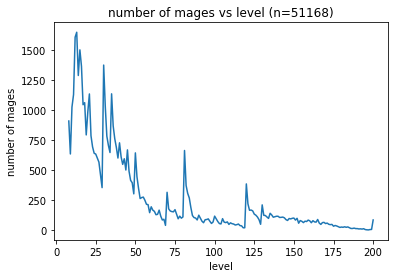

In [42]:
import matplotlib.pyplot as plt

plt.plot(df.level, df.n)
plt.title(f"number of mages vs level (n={total})")
plt.xlabel("level")
plt.ylabel("number of mages")

Text(0, 0.5, 'percentage of population')

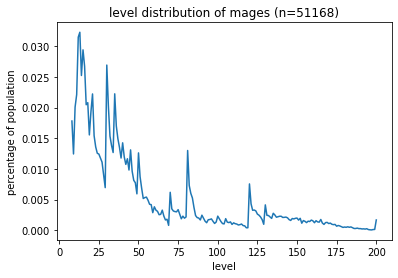

In [45]:
plt.plot(df.level, df.n/total)
plt.title(f"level distribution of mages (n={total})")
plt.xlabel("level")
plt.ylabel("percentage of population")

In [55]:
df = spark.sql("""
    select
        specialization,
        count(distinct name) as n
    from ranking
    group by 1
    order by 2 desc
""").toPandas()
df

,specialization,n
0,all,21241
1,cleric,17943
2,ice,8050
3,fire,3934


Text(0.5, 1.0, 'number of mages in each specialization')

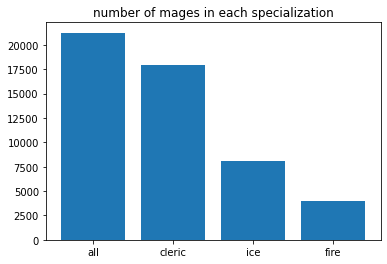

In [57]:
plt.bar(df.specialization, df.n)
plt.title("number of mages in each specialization")

Text(0.5, 1.0, 'number of mages in each specialization (level >= 30)')

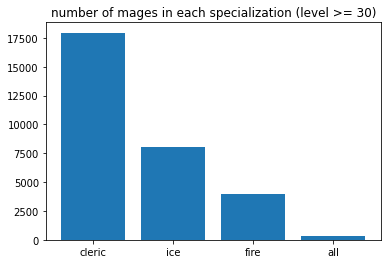

In [59]:
df = spark.sql("""
    select
        specialization,
        count(distinct name) as n
    from ranking
    where level >= 30
    group by 1
    order by 2 desc
""").toPandas()

plt.bar(df.specialization, df.n)
plt.title("number of mages in each specialization (level >= 30)")

In [126]:
df = spark.sql("""
    with specialization as (
        select name, specialization
        from ranking
    ),
    ttl as (
        select
            name,
            level,
            specialization,
            unix_timestamp(from_utc_timestamp(timestamp, "Z"))
                - unix_timestamp(from_utc_timestamp(lag(timestamp) over (partition by name order by level), "Z"))
                as diff
        from levels
        join specialization
        using (name)
    ),
    quantiles as (
        select distinct
            specialization,
            level,
            count(*) over (partition by level, specialization) as n,
            (percentile_approx(diff, 0.1) over (partition by level, specialization))/60 as p10,
            (percentile_approx(diff, 0.5) over (partition by level, specialization))/60 as p50,
            (percentile_approx(diff, 0.9) over (partition by level, specialization))/60 as p90,
            (percentile_approx(diff, 0.95) over (partition by level, specialization))/60 as p95,
            (percentile_approx(diff, 0.99) over (partition by level, specialization))/60 as p99
        from ttl
        where diff is not null
        order by 1, 2
    )
    select * 
    from quantiles
    order by specialization, level
""").cache()
df.show()

+--------------+-----+-----+------------------+------------------+------------------+------------------+------------------+
|specialization|level|    n|               p10|               p50|               p90|               p95|               p99|
+--------------+-----+-----+------------------+------------------+------------------+------------------+------------------+
|           all|    2|    3|               0.0|               0.0|               0.0|               0.0|               0.0|
|           all|    3|21120|               0.6|1.6833333333333333|              6.35|11.283333333333333| 779.7833333333333|
|           all|    4|21121|1.6333333333333333|               2.7| 7.616666666666666|17.933333333333334|           1391.65|
|           all|    5|21124|              1.95|3.6166666666666667|10.333333333333334|22.216666666666665|1861.5166666666667|
|           all|    6|21125| 3.216666666666667|               6.5|18.666666666666668|             62.05| 3033.633333333333|
|       

In [127]:
pdf = df.toPandas()

In [128]:
pdf.specialization.unique()

array(['all', 'cleric', 'fire', 'ice'], dtype=object)

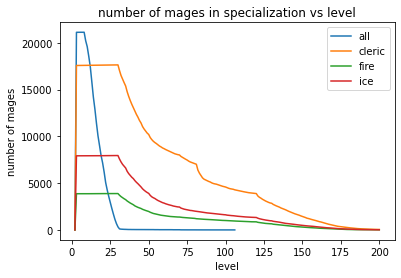

In [131]:
for name in pdf.specialization.unique():
    res = pdf[pdf.specialization == name]
    plt.plot(res.level, res.n, label=name)
plt.title("number of mages in specialization vs level")
plt.xlabel("level")
plt.ylabel("number of mages")
plt.legend()
plt.show()

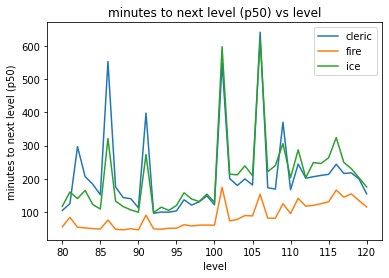

In [133]:
for name in pdf.specialization.unique():
    if name == "all":
        continue
    res = pdf[(pdf.specialization == name) & (pdf.level >= 80) & (pdf.level <= 120)]
    plt.plot(res.level, res.p50, label=name)
plt.title("minutes to next level (p50) vs level")
plt.xlabel("level")
plt.ylabel("minutes to next level (p50)")
plt.legend()
plt.show()

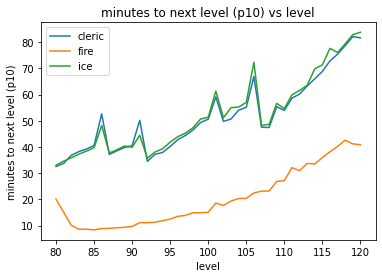

In [135]:
for name in pdf.specialization.unique():
    if name == "all":
        continue
    res = pdf[(pdf.specialization == name) & (pdf.level >= 80) & (pdf.level <= 120)]
    plt.plot(res.level, res.p10, label=name)
plt.title("minutes to next level (p10) vs level")
plt.xlabel("level")
plt.ylabel("minutes to next level (p10)")
plt.legend()
plt.show()

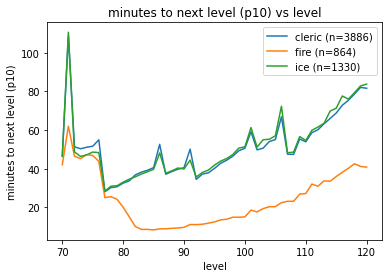

In [144]:
for name in pdf.specialization.unique():
    if name == "all":
        continue
    res = pdf[(pdf.specialization == name) & (pdf.level >= 70) & (pdf.level <= 120)]
    n = res[res.level == res.level.max()].n.values[0]
    plt.plot(res.level, res.p10, label=f"{name} (n={n})")
plt.title("minutes to next level (p10) vs level")
plt.xlabel("level")
plt.ylabel("minutes to next level (p10)")
plt.legend()
plt.show()

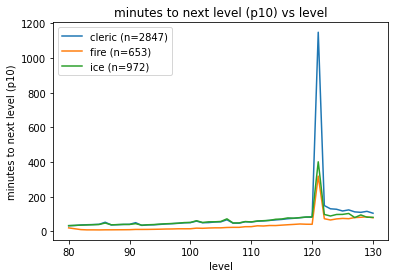

In [143]:
for name in pdf.specialization.unique():
    if name == "all":
        continue
    res = pdf[(pdf.specialization == name) & (pdf.level >= 80) & (pdf.level <= 130)]
    n = res[res.level == res.level.max()].n.values[0]
    plt.plot(res.level, res.p10, label=f"{name} (n={n})")
plt.title("minutes to next level (p10) vs level")
plt.xlabel("level")
plt.ylabel("minutes to next level (p10)")
plt.legend()
plt.show()

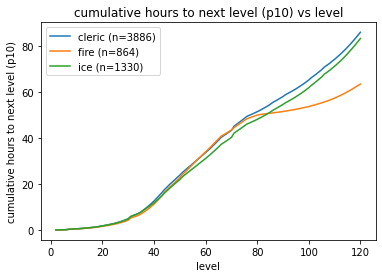

In [146]:
for name in pdf.specialization.unique():
    if name == "all":
        continue
    res = pdf[(pdf.specialization == name) & (pdf.level <= 120)]
    n = res[res.level == res.level.max()].n.values[0]
    plt.plot(res.level, res.p10.cumsum()/60, label=f"{name} (n={n})")
plt.title("cumulative hours to next level (p10) vs level")
plt.xlabel("level")
plt.ylabel("cumulative hours to next level (p10)")
plt.legend()
plt.show()